In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the network
from bayesian_torch.layers.variational_layers.conv_variational import Conv2dReparameterization_Multivariate

# LeNet
class LeNet_BNN(nn.Module):
    
    def __init__(self):
        super(LeNet_BNN, self).__init__()
        self.conv1 = Conv2dReparameterization_Multivariate(1, 6, 3, 1)
        self.conv2 = Conv2dReparameterization_Multivariate(6, 16, 3, 1)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16*12*12, 10)
        
    def forward(self, x):
        kl_sum = 0
        
        x, kl = self.conv1(x)
        kl_sum += kl
        x = F.relu(x)
        
        x, kl = self.conv2(x)
        kl_sum += kl
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = x.view(-1, 16*12*12)
        
        logit = self.fc1(x)
        
        return logit, kl_sum

class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16*12*12, 10)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = x.view(-1, 16*12*12)
        
        logit = self.fc1(x)
        
        return logit
    
# MNIST dataset

from torchvision import datasets, transforms
from tqdm import tqdm 

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

bs = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Training
bnn = LeNet_BNN()
def train_BNN(epoch, model):
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    model.cuda()
    for e in range(epoch):
        
        pbar = tqdm(enumerate(train_loader))
        for batch_idx, (data, target) in pbar:
            '''
             # compute output
            output_ = []
            kl_ = []
            for mc_run in range(args.num_mc):
                output, kl = model(input_var)
                output_.append(output)
                kl_.append(kl)
            output = torch.mean(torch.stack(output_), dim=0)
            kl = torch.mean(torch.stack(kl_), dim=0)
            '''
            data, target = data.cuda(), target.cuda()
            output_ =[]
            kl_ = []
            for mc_run in range(50):
                output, kl = model(data)
                output_.append(output)
                kl_.append(kl)
            output = torch.mean(torch.stack(output_), dim=0)
            kl = torch.mean(torch.stack(kl_), dim=0)
            
            loss = F.cross_entropy(output, target) + kl / bs # batch size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.set_description(f"Loss: {loss.item():.3f} KL: {kl.item() / bs:.3f} Epoch: {e}")
            
        print(f"Test accuracy: {test_BNN(model):.3f}")
        
def test_BNN(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            
            output_ = []
            for mc_run in range(50):
                output, _ = model(data)
                output_.append(output)
            output = torch.mean(torch.stack(output_), dim=0)
            _, predicted = torch.max(output.data, 1)
        
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

dnn = LeNet()
def train_DNN(epoch, model):
    
    
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for e in range(epoch):
        
        pbar = tqdm(enumerate(train_loader))
        for batch_idx, (data, target) in pbar:
            
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            pbar.set_description(f"Loss: {loss.item():.3f} Epoch: {epoch}")
            
        print(f"Test accuracy: {test_DNN(model):.3f}")
        
def test_DNN(model):

    model.cuda()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            _, predicted = torch.max(output.data, 1)
        
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


# train_DNN(10, dnn)
dnn.load_state_dict(torch.load('dnn.pth'))



<All keys matched successfully>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

bnn = LeNet_BNN()

# Hook 함수 정의
def hook_fn(module, input, output):
    if isinstance(module, Conv2dReparameterization_Multivariate):
        if module == bnn.conv1:
            bnn_conv1_out.append(output)
        elif module == bnn.conv2:
            bnn_conv2_out.append(output)
    elif isinstance(module, nn.AvgPool2d):
        bnn_pool_out.append(output)


# 모델 초기화
# dnn = LeNet()
bnn = LeNet_BNN()  # 실제로는 Bayesian Neural Network여야 함

# Hook을 저장할 리스트
dnn_conv1_out = []
dnn_conv2_out = []
dnn_pool_out = []
bnn_conv1_out = []
bnn_conv2_out = []
bnn_pool_out = []

# Hook 등록
dnn.conv1.register_forward_hook(lambda m, i, o: dnn_conv1_out.append(o))
dnn.conv2.register_forward_hook(lambda m, i, o: dnn_conv2_out.append(o))
dnn.pool.register_forward_hook(lambda m, i, o: dnn_pool_out.append(o))

bnn.conv1.register_forward_hook(hook_fn)
bnn.conv2.register_forward_hook(hook_fn)
bnn.pool.register_forward_hook(hook_fn)

# 옵티마이저 설정
optimizer = torch.optim.Adam(bnn.parameters(), lr=1e-3)

# Knowledge Distillation 학습 루프
epochs = 10
for e in range(epochs):
    pbar = tqdm(enumerate(train_loader))
    dnn.eval().cuda()
    bnn.train().cuda()
    
    losses = []
    for batch_idx, (data, target) in pbar:
        data, target = data.cuda(), target.cuda()
        
        with torch.no_grad():
            dnn_conv1_out.clear()
            dnn_conv2_out.clear()
            dnn_pool_out.clear()
            
            y_t = dnn(data)
            output_t = [dnn_conv1_out[0], dnn_conv2_out[0], y_t]
            
        bnn_conv1_out.clear()
        bnn_conv2_out.clear()
        bnn_pool_out.clear()
        
        y_s, _ = bnn(data)
        output_s = [bnn_conv1_out[0][0], bnn_conv2_out[0][0], y_s]
        
        loss = 0
        for idx, (t, s) in enumerate(zip(output_t, output_s)):
            loss += F.mse_loss(s, t)
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"Loss: {np.mean(losses):.3f} Epoch: {e}")


Loss: 78.019 Epoch: 0: : 118it [00:08, 14.11it/s]
Loss: 72.680 Epoch: 1: : 118it [00:07, 15.13it/s]
Loss: 63.932 Epoch: 2: : 118it [00:07, 15.09it/s]
Loss: 56.090 Epoch: 3: : 118it [00:07, 14.85it/s]
Loss: 53.571 Epoch: 4: : 118it [00:07, 14.85it/s]
Loss: 48.556 Epoch: 5: : 118it [00:07, 14.77it/s]
Loss: 49.625 Epoch: 6: : 118it [00:07, 14.93it/s]
Loss: 48.002 Epoch: 7: : 118it [00:07, 15.06it/s]
Loss: 47.509 Epoch: 8: : 118it [00:07, 15.01it/s]
Loss: 51.056 Epoch: 9: : 118it [00:07, 15.19it/s]


In [6]:
# Visualize the covariance matrix

import matplotlib.pyplot as plt
conv1_cov = bnn.conv1.get_covariance_matrix(bnn.conv1.L_param).cpu().detach().numpy()
conv2_cov = bnn.conv2.get_covariance_matrix(bnn.conv2.L_param).cpu().detach().numpy()

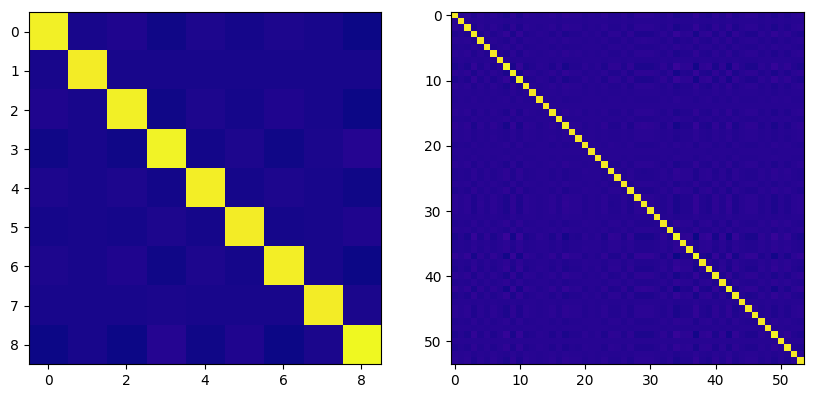

In [7]:
i=1
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(conv1_cov[:9*i,:9*i], cmap='plasma')

i=9
plt.subplot(1,2,2)
plt.imshow(conv1_cov[:9*i,:9*i], cmap='plasma')

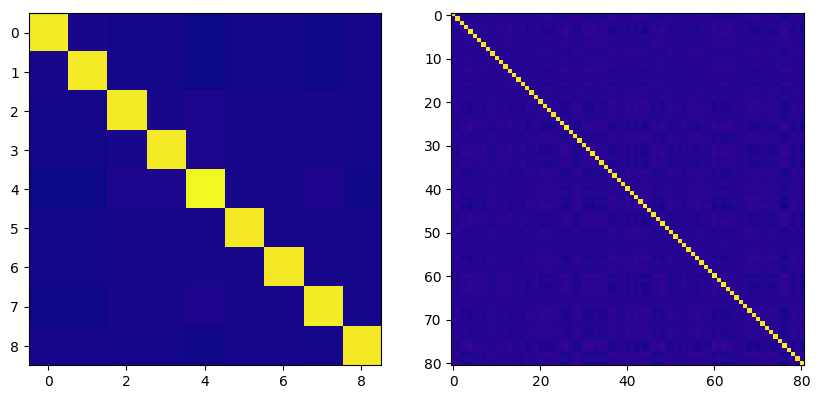

In [8]:
i=1
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(conv2_cov[:9*i,:9*i], cmap='plasma')

i=9
plt.subplot(1,2,2)
plt.imshow(conv2_cov[:9*i,:9*i], cmap='plasma')

In [9]:
bnn_with_good_prior = LeNet_BNN()
bnn_with_good_prior.conv1.L_param = bnn.conv1.L_param


In [11]:

bnn_with_good_prior = LeNet_BNN()
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param)

# bnn_with_good_prior.conv2.prior_mean = bnn.conv2.mu_kernel.detach().clone().flatten()
# bnn_with_good_prior.conv2.prior_variance = bnn.conv2.L_param.detach().clone()
# train_BNN(10, bnn_with_good_prior)


In [12]:
bnn.conv1.L_param.shape

torch.Size([1, 54])

In [ ]:
naive_bnn = LeNet_BNN()
train_BNN(10, naive_bnn)

In [ ]:
mu_q = bnn_with_good_prior.conv1.mu_kernel.view(-1)
sigma_q = bnn_with_good_prior.conv1.get_covariance_matrix()
mu_p = bnn_with_good_prior.conv1.prior_mean
sigma_p = bnn_with_good_prior.conv1.prior_variance
device = 'cuda'

print(torch.logdet(sigma_p).to(device) - torch.logdet(sigma_q).to(device))
print(torch.trace(torch.matmul(sigma_q.to(device), torch.inverse(sigma_p).to(device))))
print(torch.matmul(torch.matmul((mu_q.to(device) - mu_p.to(device)).unsqueeze(-1).permute(1, 0), torch.inverse(sigma_p.to(device))), (mu_q.cuda() - mu_p.cuda()).unsqueeze(-1)).squeeze())
print(mu_p.shape[0])
kl = torch.logdet(sigma_p).to(device) - torch.logdet(sigma_q).to(device) 
kl += torch.trace(torch.matmul(sigma_q.to(device), torch.inverse(sigma_p).to(device)))
kl += torch.matmul(torch.matmul((mu_q.to(device) - mu_p.to(device)).unsqueeze(-1).permute(1, 0), torch.inverse(sigma_p.to(device))), (mu_q.cuda() - mu_p.cuda()).unsqueeze(-1)).squeeze()
kl -= mu_p.shape[0]
kl *= 0.5
print(kl)

print("@@@")
mu_q = bnn_with_good_prior.conv2.mu_kernel.view(-1)
sigma_q = bnn_with_good_prior.conv2.get_covariance_matrix()
mu_p = bnn_with_good_prior.conv2.prior_mean
sigma_p = bnn_with_good_prior.conv2.prior_variance
device = 'cuda'

print(torch.logdet(sigma_p).to(device) - torch.logdet(sigma_q).to(device))
print(torch.trace(torch.matmul(sigma_q.to(device), torch.inverse(sigma_p).to(device))))
print(torch.matmul(torch.matmul((mu_q.to(device) - mu_p.to(device)).unsqueeze(-1).permute(1, 0), torch.inverse(sigma_p.to(device))), (mu_q.cuda() - mu_p.cuda()).unsqueeze(-1)).squeeze())
print(mu_p.shape[0])
kl = torch.logdet(sigma_p).to(device) - torch.logdet(sigma_q).to(device) 
kl += torch.trace(torch.matmul(sigma_q.to(device), torch.inverse(sigma_p).to(device)))
kl += torch.matmul(torch.matmul((mu_q.to(device) - mu_p.to(device)).unsqueeze(-1).permute(1, 0), torch.inverse(sigma_p.to(device))), (mu_q.cuda() - mu_p.cuda()).unsqueeze(-1)).squeeze()
kl -= mu_p.shape[0]
kl *= 0.5
print(kl)

In [ ]:
bnn_with_good_prior.conv2.mu_kernel.shape.numel()